# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
# < Перенесите сюда исследовательский анализ данных >

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
SEED = 12345

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(rescale=1./255)

gen_flow = datagen.flow_from_dataframe(
    dataframe = labels,
    directory = '/datasets/faces/final_files/',
    x_col = 'file_name',
    y_col = 'real_age',
    target_size = (224, 224),
    batch_size = BATCH_SIZE,
    class_mode = 'raw',
    seed = SEED)

Found 7591 validated image filenames.


**1. Посмотрим на размер выборки**

In [4]:
print(f'Размер выборки: {labels.shape}')

Размер выборки: (7591, 2)


7591 фотографий в датасете может быть недостаточно для решения задачи регрессии, особенно если в подборке разнообразные фотографии. Модель может недообучиться, поэтому нужно:
- Использовать предобученную модель для извлечения признаков, в данном случае возьмем ResNet50, обученнуя на наборе изображений ImageNet
- Использовать аугментацию, чтобы увеличить разнообразие входных данных

**2. Построим график распределения возраста в выборке**

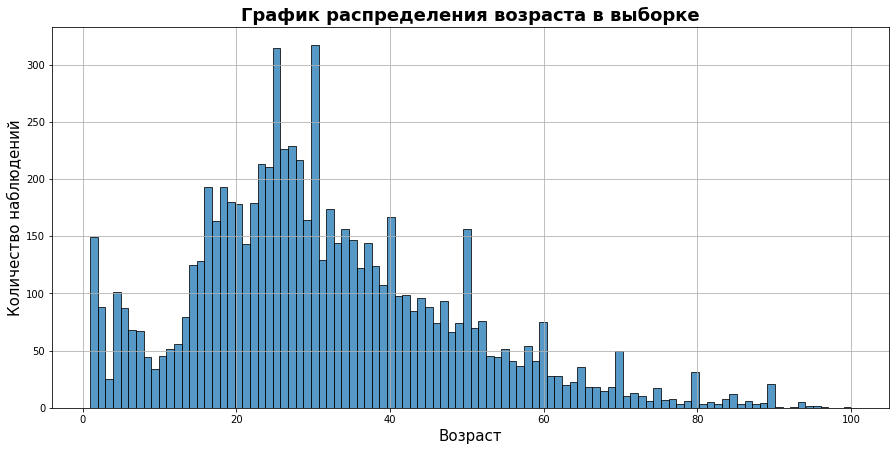

In [5]:
# извлекаем массив возрастов
ages = gen_flow.labels

plt.figure(figsize=(15, 7))
sns.histplot(ages, kde=False, bins=100)
plt.title('График распределения возраста в выборке', fontsize=18, fontweight='bold')
plt.xlabel('Возраст', fontsize=15)
plt.ylabel('Количество наблюдений', fontsize=15)
plt.grid(True)
plt.show()

**3. Напечатаем на экране 10 фотографий и посмотрим, как устроен датасет**

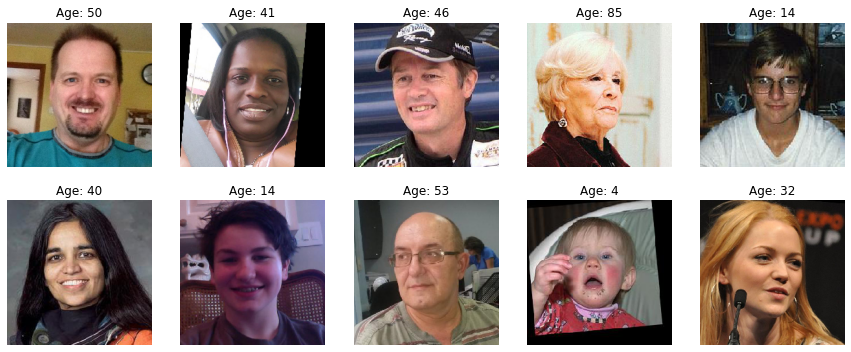

In [6]:
# получаем набор изображений и меток классов
images, labels = gen_flow.next()

# определяем сетку в 2 строки и 5 столбцов
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i])
    ax.set_title(f"Age: {labels[i]}")
    ax.axis("off")
    
plt.show()

* В данном датасете 7591 наблюдений (фотографий)
* Фотографии разнообразные, есть повернутые влево и вправо, есть с лишними предметами (ремень безопасности, кепка, очки, микрофон), из-за чего сеть иногда может допускать ошибки в предсказаниях
* Есть люди всех возрастов, но большая часть распределения в диапазоне с 20 до 30 лет, после 40 лет количество уже идет на спад. Наблюдаются пики в 26 лет и 31 год
* В целом данных достаточно для обучения модели
* Цель – добиться значения MAE на тестовой выборке не больше 8. Так как нужно предсказать одно положительное число (возраст), то это задача регрессии, будем использовать функцию активации ReLU

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import EarlyStopping

BATCH_SIZE = 32
EPOCHS = 9
LEARNING_RATE = 0.0001
SEED = 12345


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        rescale = 1./255, 
        validation_split = 0.25,
        horizontal_flip=True
    )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = BATCH_SIZE,
        class_mode = 'raw',
        subset = 'training',
        seed = SEED
    )
    
    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(
        rescale=1./255, 
        validation_split=0.25
    )
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size = (224, 224),
        batch_size = BATCH_SIZE,
        class_mode = 'raw',
        subset = 'validation',
        seed = SEED
    )
    
    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr = LEARNING_RATE)
    
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=EPOCHS, steps_per_epoch=None, validation_steps=None):
    
    # пропишем callback для остановки обучение модели, если выбранная метрика 
    # в течение 4 эпох перестанет улучшаться на валидационном наборе данных
    callback = EarlyStopping(monitor = 'val_mae', patience = 3, restore_best_weights = True)

    model.fit(train_data, 
              validation_data = test_data,
              batch_size = batch_size, 
              epochs = epochs,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              verbose = 2, 
              shuffle = True,
              callbacks=[callback])

    return model
```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/9
178/178 - 62s - loss: 257.9443 - mae: 11.5217 - val_loss: 1109.8258 - val_mae: 28.7906
Epoch 2/9
178/178 - 38s - loss: 75.2795 - mae: 6.5349 - val_loss: 1002.8248 - val_mae: 26.8465
Epoch 3/9
178/178 - 38s - loss: 53.0483 - mae: 5.5288 - val_loss: 352.5681 - val_mae: 14.1043
Epoch 4/9
178/178 - 38s - loss: 36.5005 - mae: 4.5380 - val_loss: 177.9007 - val_mae: 9.9486
Epoch 5/9
178/178 - 38s - loss: 29.3245 - mae: 4.0774 - val_loss: 95.3321 - val_mae: 7.2783
Epoch 6/9
178/178 - 38s - loss: 22.6273 - mae: 3.6255 - val_loss: 73.8359 - val_mae: 6.4042
Epoch 7/9
178/178 - 38s - loss: 17.6208 - mae: 3.2285 - val_loss: 65.0500 - val_mae: 6.0267
Epoch 8/9
178/178 - 38s - loss: 14.9312 - mae: 2.9622 - val_loss: 71.8111 - val_mae: 6.5864
Epoch 9/9
178/178 - 39s - loss: 12.0101 - mae: 2.6508 - val_loss: 62.1362 - val_mae: 5.9085

60/60 - 11s - loss: 62.1362 - mae: 5.9085
Test MAE: 5.9085
```

## Анализ обученной модели

* Нейронная сеть имеет следующую архитектуру:
    1. Класс Sequential(), который линейно соединяет слои модели
    2. Предварительно обученная модель ResNet50
    3. Слой пулинга GlobalAveragePooling2D() для обработки изображений. Он позволяет снизить размерность выходных данных и извлечь наиболее значимые признаки из изображения, которые затем используются в полносвязном слое
    4. Полносвязный слой Dense(1, activation='relu') с одним выходом (нейроном) и с функцией активации ReLU, которая возвращает только положительные значения, что идеально подходит для предсказания возраста


* Для увеличения разнообразия тренировочных данных и снижения переобучения модели добавили дополнительные преобразования для обучающих изображений (вертикальное отражение vertical_flip и сдвиги width_shift_range / height_shift_range)


* Добавили оптимизатор Adam (алгоритм стохастического градиентного спуска) с learning rate равным 0.0001 с целью минимизации функции потерь


* Добавили метод EarlyStopping для автоматической остановки обучения, если значение MSE перестанет улучшаться на валидационном наборе данных в течение 4 эпох из 12

## Вывод

* Сетевому супермаркету «Хлеб-Соль» стоит порекомендовать вышеуказанную модель, которая показала MSE не больше 8 на тестовом наборе данных

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы